In [1]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from timebudget import timebudget

def double_conv(in_channels, out_channels):
    '''Performs two successive convolution operations
    '''
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    '''Crop the tensor xdim and ydim.
     - Assumes sizes are divisible by 2
     - Assumes tensor sizes are [batch,channels,xdim,ydim]
    '''
    tensor_size = tensor.size()[2]
    target_tensor_size = target_tensor.size()[2]
    delta = (tensor_size-target_tensor_size)//2
    target = tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    return target


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(2, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)

        self.up_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.up_trans_4 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(16, 8)

        self.out = nn.Conv2d(16, 2, kernel_size=1)
        self.sig = nn.Sigmoid()
        return

    def forward(self, image):
        x1 = self.down_conv_1(image)
        #print(x1.size())

        x2 = self.maxpool_2x2(x1)
        x2 = self.down_conv_2(x2)
        #print(x2.size())

        x3 = self.maxpool_2x2(x2)
        x3 = self.down_conv_3(x3)
        #print(x3.size())

        x4 = self.maxpool_2x2(x3)
        x4 = self.down_conv_4(x4)
        #print(x4.size())

        x6 = self.up_trans_1(x4)
        #print(x6.size())
        
        x3 = crop_tensor(tensor=x3, target_tensor=x6)
        x7 = self.up_conv_1(torch.cat(tensors=[x3, x6], dim=1))
        #print(x7.size())
        
        x7 = self.up_trans_2(x7)
        x2 = crop_tensor(tensor=x2, target_tensor=x7)
        x8 = self.up_conv_2(torch.cat(tensors=[x2, x7], dim=1))
        #print(x8.size())

        x8 = self.up_trans_3(x8)
        x1 = crop_tensor(tensor=x1, target_tensor=x8)
        x9 = self.up_conv_3(torch.cat(tensors=[x1, x8], dim=1))
        #print(x9.size())

        x = self.sig(self.out(x9))
        #print(x.size())
        return x

In [2]:
#Test data
from skimage.filters import gaussian
import scipy.io as sio
D = sio.loadmat('./testdata/im260x260.mat',squeeze_me=True)
IM = D['im'].astype(float)

im_0_gauss = gaussian(IM[0,:,:], sigma=3)
im_1_gauss = gaussian(IM[1,:,:], sigma=3)
im_0_gauss = im_0_gauss/np.max(im_0_gauss)
im_1_gauss = im_1_gauss/np.max(im_1_gauss)
L = np.array(np.concatenate([np.expand_dims(im_0_gauss,0),np.expand_dims(im_1_gauss,0)],axis = 0)>0.5).astype('uint8')
L = L.astype(float)

IM_ = np.expand_dims(IM,0)
L_ = np.expand_dims(L,0)

In [3]:
unet = UNet()
optimizer = optim.Adam(unet.parameters())
mse = torch.nn.MSELoss()

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
if cuda:
    unet.cuda()
    mse.cuda()

with timebudget('Training with GPU'):
    for step in range(1000):  # loop over the dataset multiple times
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(Tensor(IM_))
        #loss = torch.sum(torch.square(outputs - )
        target = crop_tensor(Tensor(L_), outputs)
        loss = mse(outputs, target)

        loss.backward()
        optimizer.step()

        # print statistics
        if step % 100 == 0:
            print('Step {:04d} training loss: {:0.6f}'.format(step,loss.item()))

Step 0000 training loss: 0.208989
Step 0100 training loss: 0.051309
Step 0200 training loss: 0.015754
Step 0300 training loss: 0.006610
Step 0400 training loss: 0.003522
Step 0500 training loss: 0.002170
Step 0600 training loss: 0.001466
Step 0700 training loss: 0.001055
Step 0800 training loss: 0.000794
Step 0900 training loss: 0.000618
Training with GPU took 16.765sec


In [4]:
#Checks - plot 
input_size = 260
output_size = 172
crop_size = (input_size-output_size)//2

In [5]:
#tensors have format: [index,channel,height,width]

#Tensors have to be brought to cpu before conversion to numpy
if torch.cuda.is_available():
    lbl = crop_tensor(Tensor(L_), outputs).cpu().numpy()
    img = Tensor(IM_).cpu().numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()
else:
    lbl = crop_tensor(Tensor(L_), outputs).numpy()
    img = Tensor(IM_).numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()

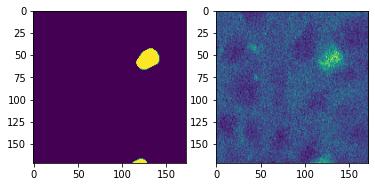

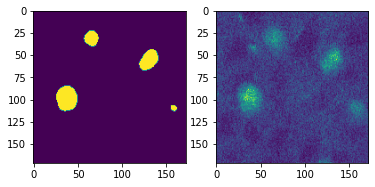

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,0,:,:])
plt.subplot(122)
plt.imshow(img[0,0,:,:])

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,1,:,:])
plt.subplot(122)
plt.imshow(img[0,1,:,:])
plt.show()

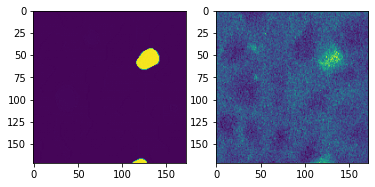

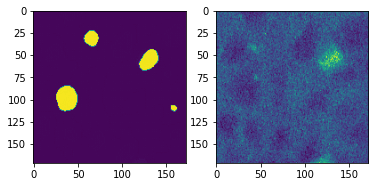

In [7]:
#Show predictions for overfitted example
plt.figure()
plt.subplot(121)
plt.imshow(pred[0,0,:,:])
plt.subplot(122)
plt.imshow(img[0,0,:,:])

plt.figure()
plt.subplot(121)
plt.imshow(pred[0,1,:,:])
plt.subplot(122)
plt.imshow(img[0,0,:,:])
plt.show()

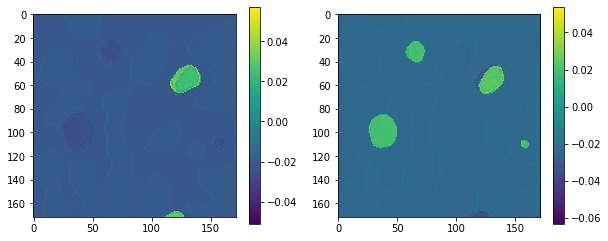

In [8]:
#Checks - plot differences between label and pred
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.imshow(lbl[0,0,:,:]-pred[0,0,:,:])
plt.colorbar()

plt.subplot(122)
plt.imshow(lbl[0,1,:,:]-pred[0,1,:,:])
plt.colorbar()
plt.show()